<a href="https://colab.research.google.com/github/chunyagi/BERTime/blob/main/TimeLLM_BERT_diversity_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TimeLLM Replication with BERT

This notebook replicates the TimeLLM architecture (paper: https://arxiv.org/abs/2310.01728) using BERT (instead of LLaMA-7B) as the backbone language model. We'll use the ETTh1 dataset for experimentation.

## Research Topic: Time Series Forecasting with LLM

**Core idea:** Using a pre-trained LLM encoder as a feature extractor to generate time series embeddings for forecasting task

## Identify the Forecasting Task

In this notebook, we perform long-term forecasting (LTF) on ETTh1 with the following setup:
- Input sequence length: 512 hourly data points (~21 days of history)
- Forecast horizon: 96 hourly data points (4 days into the future)
- Forecasting type: Multivariate forecasting

## 0. Get Setup

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch import nn, optim
from torch.optim import lr_scheduler
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel

from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.cluster import KMeans

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import json
from typing import Optional, Tuple, Dict, Any
from types import SimpleNamespace
import time
import random
import gdown
import shutil
from google.colab import files

# Download torchinfo if it's not installed locally
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [2]:
# Setup device agnostic code
def set_device():
  if torch.cuda.is_available():
    device = "cuda"
  elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = "mps"
  else:
    device = "cpu"
  return device

device = set_device()
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


**Note:** NVIDIA A100 GPU (40GB VRAM) is used in this notebook for training and inference.

## 1. Download data

In [3]:
import gdown

# Download the dataset folder from google drive
folder_id = "1zeE7DYcjgoFWo3A3TZS31oUzIT_wOMnk"
gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}",
                     output="./dataset",
                     quiet=False,
                     use_cookies=False)

Retrieving folder contents


Processing file 1PFOpWyIlhVfWRbkyCdaekGjDwUOVqsu3 ETTh1.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1PFOpWyIlhVfWRbkyCdaekGjDwUOVqsu3
To: /content/dataset/ETTh1.csv
100%|██████████| 1.75M/1.75M [00:00<00:00, 141MB/s]
Download completed


['./dataset/ETTh1.csv']

## 2. Create Datasets and Dataloaders

### 2.1 Encode Time Features

**Note:** The baseline model doesn't utilize encoded time features.

In [4]:
from typing import List

import numpy as np
import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset


class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"


class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5


class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5


class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5


class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5


class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5


class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5


class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5


class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.isocalendar().week - 1) / 52.0 - 0.5


def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)


def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

### 2.2 Create Custom Dataset class for ETTh1

In [5]:
import os
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
# from utils.timefeatures import time_features
import warnings

warnings.filterwarnings('ignore')


class Dataset_ETT_hour(Dataset):
    def __init__(self,
                 root_path: str,
                 flag: str = 'train',
                 size: Optional[Tuple[int, int, int]] = None,
                 features: str = 'S', # 'M': multivariate predict multivariate, 'S': univariate, 'MS': multivariate predict univariate
                 data_path: str = 'ETTh1.csv',
                 target: str = 'OT',
                 scale: bool = True,
                 timeenc: int = 0, # 0: no time encoding, 1: use time features
                 freq: str = 'h',
                 percent: int = 100,
                 seasonal_patterns=None, # Not sure what type it has
                 pretrain: bool = True):

        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]

        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag] # Type 0, 1 or 2

        self.percent = percent
        self.pretrain = pretrain
        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        # self.percent = percent
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

        self.enc_in = self.data_x.shape[-1] # Number of features
        self.tot_len = len(self.data_x) - self.seq_len - self.pred_len + 1 # Number of time windows

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        if self.pretrain:
            # border1s = [0, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len]
            # border2s = [12 * 30 * 24 + 8 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]
            border1s = [0, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len]
            border2s = [12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]
        else:
            border1s = [0, 12 * 30 * 24 - self.seq_len, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len]
            border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]

        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.set_type == 0:
            border2 = (border2 - self.seq_len) * self.percent // 100 + self.seq_len

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], axis=1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        feat_id = index // self.tot_len
        s_begin = index % self.tot_len

        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len
        seq_x = self.data_x[s_begin:s_end, feat_id:feat_id + 1] # [seq_len, 1]
        seq_y = self.data_y[r_begin:r_end, feat_id:feat_id + 1] # [label_len + pred_len, 1]
        seq_x_mark = self.data_stamp[s_begin:s_end] # [seq_len, num_time_features]
        seq_y_mark = self.data_stamp[r_begin:r_end] # [label_len + pred_len, num_time_features]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return (len(self.data_x) - self.seq_len - self.pred_len + 1) * self.enc_in

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

In [6]:
# Test dataset class
dataset = Dataset_ETT_hour(
    root_path='dataset',
    flag='train',
    size=(512, 48, 96),   # seq_len, label_len, pred_len
    features='MS',
    timeenc=1,
    pretrain=True
)

print(f"Dataset length: {len(dataset)}")
print(f"Number of features: {dataset.enc_in}")

Dataset length: 76391
Number of features: 7


In [7]:
# Get one sample
seq_x, seq_y, seq_x_mark, seq_y_mark = dataset[0]
print(f"Input sequence shape: {seq_x.shape}")
print(f"Target sequence shape: {seq_y.shape}")
print(f"Input time features shape: {seq_x_mark.shape}")
print(f"Target time features shape: {seq_y_mark.shape}")

Input sequence shape: (512, 1)
Target sequence shape: (144, 1)
Input time features shape: (512, 4)
Target time features shape: (144, 4)


### 2.2 Create Data Provider class (wrapper class to create datasets and dataloaders)

In [8]:
from torch.utils.data import DataLoader

data_dict = {
    'ETTh1': Dataset_ETT_hour,
    'ETTh2': Dataset_ETT_hour,
}

def data_provider(args, flag):
    """
    Create dataset and dataloader for time series forecasting.

    Args:
        args: Configuration object (argparse.Namespace) containing:
            - embed: bool, whether to use time embeddings (!= 'timeF')
            - percent: int, percentage of training data to use
            - batch_size: int, batch size for DataLoader
            - freq: str, frequency of time series ('h', 'm', etc.)
            - seq_len: int, input sequence length
            - label_len: int, label sequence length
            - pred_len: int, prediction sequence length
            - features: str, feature mode ('M', 'S', 'MS')
            - target: str, target column name
            - num_workers: int, number of DataLoader workers
            - seasonal_patterns: optional, seasonal pattern information
        data (str): Dataset identifier key
        data_path (str): Path to the dataset file
        pretrain (bool, optional): Whether to use pretraining data splits
        flag (str, optional): Dataset split type

    Returns:
        tuple: A tuple containing:
            - data_set: Dataset instance configured with specified parameters
            - data_loader: DataLoader instance with appropriate batching and
                           shuffling settings
    """
    Data = data_dict[args.data]
    timeenc = 0 if args.embed != 'timeF' else 1
    percent = args.percent

    if flag == 'test':
        shuffle_flag = False
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq
    else:
        shuffle_flag = True
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq

    if args.data == 'm4':
        drop_last = False
        data_set = Data(
            root_path=args.root_path,
            data_path=args.data_path,
            flag=flag,
            size=[args.seq_len, args.label_len, args.pred_len],
            features=args.features,
            target=args.target,
            timeenc=timeenc,
            freq=freq,
            seasonal_patterns=args.seasonal_patterns
        )
    else:
        data_set = Data(
            root_path=args.root_path,
            data_path=args.data_path,
            flag=flag,
            size=[args.seq_len, args.label_len, args.pred_len],
            features=args.features,
            target=args.target,
            timeenc=timeenc,
            freq=freq,
            percent=percent,
            seasonal_patterns=args.seasonal_patterns
        )
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)
    return data_set, data_loader

In [9]:
# Test data provider class
from types import SimpleNamespace

# Setup arguments
args = SimpleNamespace(
    data='ETTh1', data_path='ETTh1.csv', embed='timeF', percent=100, batch_size=128, freq='h',
    seq_len=512, label_len=48, pred_len=192, features='M', target='OT', num_workers=2, root_path='dataset', seasonal_patterns=None
)

# Get training dataset and dataloader
train_data, train_loader = data_provider(args, flag='train')
print(f"Dataset size: {len(train_data)}")
print(f"Number of batches: {len(train_loader)}")

# Get the first batch from the training dataloader
batch_seq_x, batch_seq_y, batch_seq_x_mark, batch_seq_y_mark = next(iter(train_loader))
print(f"Batch shapes: {batch_seq_x.shape}, {batch_seq_x_mark.shape}, {batch_seq_y.shape}, {batch_seq_y_mark.shape}")

Dataset size: 75719
Number of batches: 591
Batch shapes: torch.Size([128, 512, 1]), torch.Size([128, 512, 4]), torch.Size([128, 240, 1]), torch.Size([128, 240, 4])


## 3. Replicate Time-LLM architecture

Steps:
1. Normalizing layer (RevIN)
2. Patch embedding layer
3. Reprogramming layer
4. Flattening head
5. Model class

### 3.1 Normalizing layer (RevIN)

A normalizing layer which normalizes input data and rescales the model predictions back to their original scale.

In [10]:
import torch
import torch.nn as nn

class Normalize(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=False, subtract_last=False, non_norm=False):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(Normalize, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        self.non_norm = non_norm
        if self.affine:
            self._init_params()

    def forward(self, x, mode: str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else:
            raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim - 1))
        if self.subtract_last:
            self.last = x[:, -1, :].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.non_norm:
            return x
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.non_norm:
            return x
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x

## 3.2 Patch Embedding Layer

Input shape: `(batch_size, num_features, seq_len)`

Inside the class:
1. `ReplicationPad1d` (Padding): When the `patch_len` is incompatible with `seq_len` (i.e., `(seq_len - patch_len) % stride != 0`), the padding layer repeats the last timestep values until the sequence becomes compatible with the patching parameters (`patch_len`, `stride`)

3. After padding, `unfold()` is used to create (non-) overlapping patches. The tensor shape becomes: `(batch_size, num_features, num_patches, patch_len)`

4. `TokenEmbedding` (Embedding): The patches are embedded into `d_model`-dim embeddings using `Conv1d`:
  - Reshape input from `(batch_size, num_features, num_patches, patch_len)` to `(batch_size*num_features, patch_len, num_patches)`
  - Apply Conv1d with `in_channels=patch_len` and `out_channels=d_model` (number of kernels)
  - Transpose the output to get final shape: `(batch_size*num_features, num_patches, d_model)`

5. Dropout layer

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn.utils import weight_norm
import math


class ReplicationPad1d(nn.Module):
    """
    Custom 1D replication padding for handling sequence length issues

    Replicates the last value of the sequence to reach desired padding length.
    """
    def __init__(self, padding) -> None:
        super(ReplicationPad1d, self).__init__()
        self.padding = padding

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Apply replication padding

        Args:
            input: Input tensor of shape [batch_size, num_features, seq_len]

        Returns:
            Padded tensor
        """
        replicate_padding = input[:, :, -1].unsqueeze(-1).repeat(1, 1, self.padding[-1])
        output = torch.cat([input, replicate_padding], dim=-1)
        return output


class TokenEmbedding(nn.Module):
    """
    Converts patches of time series data into dense embeddings using Conv1d.
    """
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False) # Assume kernel stride=1

        # Initialize Conv1d weights using Kaiming normal initialization
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        """
        Args:
            x: Input tensor [batch_size*num_features, patches_num, patch_len]

        Returns:
            Embedded tensor [batch_size*num_features, patches_num, d_model]
        """
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class PatchEmbedding(nn.Module):
    """
    Converts time series into (non-) overlapping patches and embeds them into dense vectors.
    This is the first step in preparing time series data for LLM processing.
    """

    def __init__(self, d_model, patch_len, stride, dropout):
        super(PatchEmbedding, self).__init__()
        # Patching
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch_layer = ReplicationPad1d((0, stride)) # Padding by stride guarantees the final patch

        # Backbone, Input encoding: projection of feature vectors onto a d_model-dim vector space
        self.value_embedding = TokenEmbedding(patch_len, d_model)

        # Positional embedding
        # self.position_embedding = PositionalEmbedding(d_model)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Args:
            x: Input time series tensor [batch_size, num_features, seq_len]

        Returns:
            Tuple of (patch_embeddings, num_features)
            - patch_embeddings: [batch_size*num_features, patches_num, d_model]
            - n_vars: Number of features in the original input
        """
        # do patching
        n_vars = x.shape[1]
        x = self.padding_patch_layer(x)
        x = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        # Input encoding
        x = self.value_embedding(x)
        return self.dropout(x), n_vars

In [12]:
# pe = PatchEmbedding(168, 16, 8, 0.1).float().to(device)
# pe(fixed_batch_tuple[0].permute(0, 2, 1))[0].shape

### 3.3 Reprogramming Layer

In [13]:
from math import sqrt

class ReprogrammingLayer(nn.Module):
    """
    Cross-modal attention layer for reprogramming between different embedding spaces.

    This layer enables a model trained on one modality (e.g., language) to process
    another modality (e.g., time series) by learning cross-attention mappings between
    the target domain and source domain embeddings.
    """

    def __init__(self, d_model, n_heads, d_keys=None, d_llm=None, attention_dropout=0.1):
        super(ReprogrammingLayer, self).__init__()

        # Set default key dimension if not provided
        d_keys = d_keys or (d_model // n_heads)

        # Projection layers for multi-head attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_llm, d_keys * n_heads)
        self.value_projection = nn.Linear(d_llm, d_keys * n_heads)
        self.out_projection = nn.Linear(d_keys * n_heads, d_llm)
        self.n_heads = n_heads
        self.dropout = nn.Dropout(attention_dropout)

        self.track_attention   = False
        self.attention_weights = None

    def forward(self, target_embedding, source_embedding, value_embedding):
        """
        Args:
            target_embedding (torch.Tensor): Target domain embeddings [B, L, d_model]
                                            (e.g., time series patch embeddings)
            source_embedding (torch.Tensor): Source domain key embeddings [S, d_llm]
                                            (e.g., LLM token embeddings for keys)
            value_embedding (torch.Tensor): Source domain value embeddings [S, d_llm]
                                           (e.g., LLM token embeddings for values)

        Returns:
            torch.Tensor: Reprogrammed embeddings [B, L, d_llm]
        """
        B, L, _ = target_embedding.shape
        S, _ = source_embedding.shape
        H = self.n_heads

        target_embedding = self.query_projection(target_embedding).view(B, L, H, -1) # (B, L, H, d_keys * n_heads)
        source_embedding = self.key_projection(source_embedding).view(S, H, -1) # (S, H, d_keys * n_heads)
        value_embedding = self.value_projection(value_embedding).view(S, H, -1) # (S, H, d_keys * n_heads)

        out = self.reprogramming(target_embedding, source_embedding, value_embedding)

        out = self.out_projection(out.reshape(B, L, -1))

        # stash out the output
        self.out = out

        return out
        # return self.out_projection(out)

    def reprogramming(self, target_embedding, source_embedding, value_embedding):
        """
        Core cross-attention reprogramming mechanism.

        Args:
            target_embedding (torch.Tensor): Query embeddings from target domain
            source_embedding (torch.Tensor): Key embeddings from source domain
            value_embedding (torch.Tensor): Value embeddings from source domain

        Returns:
            torch.Tensor: Reprogrammed embeddings combining target and source info
                         Shape: [B, L, H, E] - same as target_embedding
        """
        B, L, H, E = target_embedding.shape

        scale = 1. / sqrt(E)

        scores = torch.einsum("blhe,she->bhls", target_embedding, source_embedding)

        # A = self.dropout(torch.softmax(scale * scores, dim=-1))
        A = torch.softmax(scale * scores, dim=-1)

        # Stash out attention if tracking is on
        if self.track_attention:
            self.attention_weights = A.detach().clone()

        A = self.dropout(A)

        reprogramming_embedding = torch.einsum("bhls,she->blhe", A, value_embedding)

        return reprogramming_embedding

    def enable_attention_tracking(self):
        """Call before your fixed-sample forward to start capturing."""
        self.track_attention = True

    def disable_attention_tracking(self):
        """Stop capturing after you’ve pulled the weights."""
        self.track_attention = False

    def get_attention_weights(self):
        """Return the last captured [B, H, L, S] tensor."""
        return self.attention_weights

    def get_reprogramming_embedding(self):
        """Return reprogramming embeddings of shape [B, L, d_llm]."""
        return self.out

### 3.4 Flattening Head

In [14]:
class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x

### 3.5 Model Class

In [15]:
from math import sqrt

import torch
import torch.nn as nn

from transformers import LlamaConfig, LlamaModel, LlamaTokenizer, GPT2Config, GPT2Model, GPT2Tokenizer, BertConfig, \
    BertModel, BertTokenizer
# from layers.Embed import PatchEmbedding
import transformers
# from layers.StandardNorm import Normalize

transformers.logging.set_verbosity_error()

class Model(nn.Module):

    def __init__(self, configs, patch_len=16, stride=8):
        super(Model, self).__init__()
        self.task_name = configs.task_name
        self.pred_len = configs.pred_len
        self.seq_len = configs.seq_len
        self.d_ff = configs.d_ff
        self.top_k = 5
        self.d_llm = configs.llm_dim
        self.patch_len = configs.patch_len
        self.stride = configs.stride

        if configs.llm_model == 'LLAMA':
            # self.llama_config = LlamaConfig.from_pretrained('/mnt/alps/modelhub/pretrained_model/LLaMA/7B_hf/')
            self.llama_config = LlamaConfig.from_pretrained('huggyllama/llama-7b')

            self.llama_config.num_hidden_layers = configs.llm_layers
            self.llama_config.output_attentions = True
            self.llama_config.output_hidden_states = True
            try:
                self.llm_model = LlamaModel.from_pretrained(
                    # "/mnt/alps/modelhub/pretrained_model/LLaMA/7B_hf/",
                    'huggyllama/llama-7b',
                    trust_remote_code=True,
                    local_files_only=True,
                    config=self.llama_config,
                    # load_in_4bit=True
                )
            except EnvironmentError:  # download model from HF if not already done
                print("Local model files not found. Attempting to download...")
                self.llm_model = LlamaModel.from_pretrained(
                    # "/mnt/alps/modelhub/pretrained_model/LLaMA/7B_hf/",
                    'huggyllama/llama-7b',
                    trust_remote_code=True,
                    local_files_only=False,
                    config=self.llama_config,
                    # load_in_4bit=True
                )
            try:
                self.tokenizer = LlamaTokenizer.from_pretrained(
                    # "/mnt/alps/modelhub/pretrained_model/LLaMA/7B_hf/tokenizer.model",
                    'huggyllama/llama-7b',
                    trust_remote_code=True,
                    local_files_only=True
                )
            except EnvironmentError:  # download the tokenizer from HF if not already done
                print("Local tokenizer files not found. Atempting to download them..")
                self.tokenizer = LlamaTokenizer.from_pretrained(
                    # "/mnt/alps/modelhub/pretrained_model/LLaMA/7B_hf/tokenizer.model",
                    'huggyllama/llama-7b',
                    trust_remote_code=True,
                    local_files_only=False
                )
        elif configs.llm_model == 'DistilGPT2':
            self.gpt2_config = GPT2Config.from_pretrained('distilgpt2')

            self.gpt2_config.num_hidden_layers = configs.llm_layers
            self.gpt2_config.output_attentions = True
            self.gpt2_config.output_hidden_states = True
            try:
                self.llm_model = GPT2Model.from_pretrained(
                    'distilgpt2',
                    trust_remote_code=True,
                    local_files_only=False,
                    config=self.gpt2_config,
                )
            except EnvironmentError:  # downloads model from HF is not already done
                print("Local model files not found. Attempting to download...")
                self.llm_model = GPT2Model.from_pretrained(
                    'distilgpt2',
                    trust_remote_code=True,
                    local_files_only=False,
                    config=self.gpt2_config,
                )

            try:
                self.tokenizer = GPT2Tokenizer.from_pretrained(
                    'distilgpt2',
                    trust_remote_code=True,
                    local_files_only=False
                )
            except EnvironmentError:  # downloads the tokenizer from HF if not already done
                print("Local tokenizer files not found. Attempting to download them..")
                self.tokenizer = GPT2Tokenizer.from_pretrained(
                    'distilgpt2',
                    trust_remote_code=True,
                    local_files_only=False
                )
        elif configs.llm_model == 'DistilBert':
            self.bert_config = BertConfig.from_pretrained('distilbert-base-uncased')

            self.bert_config.num_hidden_layers = configs.llm_layers
            self.bert_config.output_attentions = True
            self.bert_config.output_hidden_states = True
            try:
                self.llm_model = BertModel.from_pretrained(
                    'distilbert-base-uncased',
                    trust_remote_code=True,
                    local_files_only=False,
                    config=self.bert_config,
                )
            except EnvironmentError:  # downloads model from HF is not already done
                print("Local model files not found. Attempting to download...")
                self.llm_model = BertModel.from_pretrained(
                    'distilbert-base-uncased',
                    trust_remote_code=True,
                    local_files_only=False,
                    config=self.bert_config,
                )

            try:
                self.tokenizer = BertTokenizer.from_pretrained(
                    'distilbert-base-uncased',
                    trust_remote_code=True,
                    local_files_only=False
                )
            except EnvironmentError:  # downloads the tokenizer from HF if not already done
                print("Local tokenizer files not found. Atempting to download them..")
                self.tokenizer = BertTokenizer.from_pretrained(
                    'distilbert-base-uncased',
                    trust_remote_code=True,
                    local_files_only=False
                )
        else:
            raise Exception('LLM model is not defined')

        if self.tokenizer.eos_token:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        else:
            pad_token = '[PAD]'
            self.tokenizer.add_special_tokens({'pad_token': pad_token})
            self.tokenizer.pad_token = pad_token

        for param in self.llm_model.parameters():
            param.requires_grad = False

        if configs.prompt_domain:
            self.description = configs.content
        else:
            self.description = 'The Electricity Transformer Temperature (ETT) is a crucial indicator in the electric power long-term deployment. This dataset consists of 2 years data from two separated counties in China. To explore the granularity on the Long sequence time-series forecasting (LSTF) problem, different subsets are created, {ETTh1, ETTh2} for 1-hour-level and ETTm1 for 15-minutes-level. Each data point consists of the target value ”oil temperature” and 6 power load features. The train/val/test is 12/4/4 months.'

        self.dropout = nn.Dropout(configs.dropout)

        self.patch_embedding = PatchEmbedding(
            configs.d_model, self.patch_len, self.stride, configs.dropout)

        self.word_embeddings = self.llm_model.get_input_embeddings().weight
        self.vocab_size = self.word_embeddings.shape[0]
        self.num_tokens = configs.num_tokens  # text prototype size
        self.mapping_layer = nn.Linear(self.vocab_size, self.num_tokens, bias=False)  # map vocabs to text prototypes (V -> V')
        self.proto_tau = configs.proto_tau  # softmax temperature

        self.reprogramming_layer = ReprogrammingLayer(configs.d_model, configs.n_heads, self.d_ff, self.d_llm)

        self.patch_nums = int((configs.seq_len - self.patch_len) / self.stride + 2) # +2 because ReplicationPad1d adds padding of length stride
        self.head_nf = self.d_ff * self.patch_nums

        if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
            self.output_projection = FlattenHead(configs.enc_in, self.head_nf, self.pred_len,
                                                 head_dropout=configs.dropout)
        else:
            raise NotImplementedError

        self.normalize_layers = Normalize(configs.enc_in, affine=False)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
            dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
            return dec_out[:, -self.pred_len:, :]
        return None

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):

        x_enc = self.normalize_layers(x_enc, 'norm')

        B, T, N = x_enc.size()
        x_enc = x_enc.permute(0, 2, 1).contiguous().reshape(B * N, T, 1) # (B, T, 1)

        min_values = torch.min(x_enc, dim=1)[0] # (B, 1)
        max_values = torch.max(x_enc, dim=1)[0] # (B, 1)
        medians = torch.median(x_enc, dim=1).values # (B, 1)
        lags = self.calcute_lags(x_enc) # (B, top_k)
        trends = x_enc.diff(dim=1).sum(dim=1) # (B, 1)

        prompt = [] # contains prompts for all samples in a batch
        for b in range(x_enc.shape[0]):
            min_values_str = str(min_values[b].tolist()[0])
            max_values_str = str(max_values[b].tolist()[0])
            median_values_str = str(medians[b].tolist()[0])
            lags_values_str = str(lags[b].tolist())
            prompt_ = (
                f"<|start_prompt|>Dataset description: {self.description}"
                f"Task description: forecast the next {str(self.pred_len)} steps given the previous {str(self.seq_len)} steps information; "
                "Input statistics: "
                f"min value {min_values_str}, "
                f"max value {max_values_str}, "
                f"median value {median_values_str}, "
                f"the trend of input is {'upward' if trends[b] > 0 else 'downward'}, "
                f"top 5 lags are : {lags_values_str}<|<end_prompt>|>"
            )
            # print(self.description)
            prompt.append(prompt_)

        x_enc = x_enc.reshape(B, N, T).permute(0, 2, 1).contiguous() # (B, T, N)

        prompt = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=2048).input_ids # (batch, prompt_token)
        prompt_embeddings = self.llm_model.get_input_embeddings()(prompt.to(x_enc.device))  # (batch, num_prompt_token, d_llm)

        source_embeddings = self.mapping_layer(self.word_embeddings.permute(1, 0)).permute(1, 0) # (V', d_llm)
        self.source_embeddings = source_embeddings

        # Softmax
        # mapping_weight_mat = self.mapping_layer.weight # (V', V)
        # norm_mapping_weight_mat = torch.softmax(mapping_weight_mat / self.proto_tau, dim=1)
        # source_embeddings = norm_mapping_weight_mat @ self.word_embeddings  # (V', d_llm)

        x_enc = x_enc.permute(0, 2, 1).contiguous() # (B, N, T)
        # enc_out, n_vars = self.patch_embedding(x_enc.to(torch.bfloat16)) # (batch, patch_nums, d_model)
        enc_out, n_vars = self.patch_embedding(x_enc) # (batch, num_patches, d_model)
        enc_out = self.reprogramming_layer(enc_out, source_embeddings, source_embeddings)
        llama_enc_out = torch.cat([prompt_embeddings, enc_out], dim=1)
        dec_out = self.llm_model(inputs_embeds=llama_enc_out).last_hidden_state # (batch, num_prompt_token + num_patches, d_llm)
        dec_out = dec_out[:, :, :self.d_ff] # only taking the first d_ff(d_keys) dimensions to pass onto the flatten head

        dec_out = torch.reshape(
            dec_out, (-1, n_vars, dec_out.shape[-2], dec_out.shape[-1])) # (batch, 1, num_tokens, d_ff)
        dec_out = dec_out.permute(0, 1, 3, 2).contiguous() # (batch, 1, d_ff, num_tokens)

        dec_out = self.output_projection(dec_out[:, :, :, -self.patch_nums:]) # (batch, 1, pred_len)
        dec_out = dec_out.permute(0, 2, 1).contiguous() # (batch, pred_len, 1)

        dec_out = self.normalize_layers(dec_out, 'denorm')

        return dec_out

    def calcute_lags(self, x_enc):
        q_fft = torch.fft.rfft(x_enc.permute(0, 2, 1).contiguous(), dim=-1)
        k_fft = torch.fft.rfft(x_enc.permute(0, 2, 1).contiguous(), dim=-1)
        res = q_fft * torch.conj(k_fft)
        corr = torch.fft.irfft(res, dim=-1)
        mean_value = torch.mean(corr, dim=1)
        _, lags = torch.topk(mean_value, self.top_k, dim=-1)
        return lags

In [16]:
# # Create an instance of TimeLLM model for testing
# model = Model(args).float()

# # Count parameters
# total, trainable = count_parameters(model, "TimeLLM")

In [17]:
# # Get a summary
# summary(model=model,
#         input_size=[(128, 512, 1), (128, 512, 4), (128, 144, 1), (128, 144, 4)],  # x_enc, x_mark_enc, x_dec, x_mark_dec
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [18]:
# # Check the rank of the embedding matrix of BERT
# emb_matrix = model.llm_model.get_input_embeddings().weight.detach()

# # # Compute the numerical rank
# rank = torch.linalg.matrix_rank(emb_matrix)
# print(f"Embedding matrix shape: {emb_matrix.shape}")
# print(f"Numerical rank: {rank}")

## 4. Setup training code

### 4.1 Setup Training Configurations

In [19]:
# Basic Config
args = SimpleNamespace()
args.task_name = 'long_term_forecast'
args.is_training = 1 # Not used
args.model_id = 'ETTh1_512_96'
args.model_comment = 'TimeLLM-ETTh1-baseline'
args.model = 'TimeLLM'
args.seed = 2021

In [20]:
# Data Config
args.data = 'ETTh1'
args.root_path = './dataset'
args.data_path = 'ETTh1.csv'
args.features = 'M'
args.target = 'OT'
args.loader = 'modal' # Not used
args.freq = 'h'
args.checkpoints = './checkpoints/'

In [21]:
# Task Config
args.seq_len = 512
args.label_len = 48
args.pred_len = 96
args.seasonal_patterns = 'Monthly' # Not used

In [22]:
# Model Config
args.proto_tau = 1.0  # softmax tmeperature
args.row_overlap_lambda = 0.05  # base lambda
args.enc_in = 7  # Not used (when affine=False)
args.dec_in = 7  # Not used
args.c_out = 7  # Not used
args.d_model = 32
args.n_heads = 8
args.num_tokens = 100 # text prototypes size
args.e_layers = 2  # Not used
args.d_layers = 1  # Not used
args.d_ff = 128
args.moving_avg = 25  # Not used
args.factor = 3  # Not used
args.dropout = 0.1
args.embed = 'timeF'
args.activation = 'gelu'  # Not used
args.output_attention = False
args.patch_len = 16
args.stride = 8
args.prompt_domain = 0
args.llm_model = 'DistilBert'
args.llm_dim = 768

In [23]:
# Training Config
args.num_workers = 2 # Google Colab's hardware
args.itr = 1
args.train_epochs = 50
args.align_epochs = 10  # Not used
args.batch_size = 256
args.eval_batch_size = 8  # Not used
args.patience = 10
args.learning_rate = 0.01
args.des = 'Exp'
args.loss = 'MSE'
args.lradj = 'type1'
args.pct_start = 0.2
args.use_amp = False
args.llm_layers = 6
args.percent = 100

### 4.2 EarlyStopping class

In [24]:
class EarlyStopping:
    def __init__(self, accelerator=None, patience=7, verbose=False, delta=0, save_mode=True):
        self.accelerator = accelerator
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        # self.val_loss_min = np.Inf
        self.val_loss_min = np.inf
        self.delta = delta
        self.save_mode = save_mode

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            if self.save_mode:
                self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.accelerator is None:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            else:
                self.accelerator.print(f'EarlyStopping counter: {self.counter} out of {self.patience}') # For distributed training (multiple GPUs)
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            if self.save_mode:
                self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            if self.accelerator is not None:
                self.accelerator.print(
                    f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            else:
                print(
                    f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')

        if self.accelerator is not None:
            model = self.accelerator.unwrap_model(model)
            torch.save(model.state_dict(), path + '/' + 'checkpoint')
        else:
            torch.save(model.state_dict(), path + '/' + 'checkpoint')
        self.val_loss_min = val_loss

### 4.3 Uitlity Functions

In [25]:
def count_parameters(model, model_name="Model"):
   """
   Count and print the number of parameters in a PyTorch model

   Args:
       model: PyTorch model
       model_name: Name of the model for display

   Returns:
       tuple: (total_params, trainable_params)
   """
   total_params = sum(p.numel() for p in model.parameters())
   trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
   frozen_params = total_params - trainable_params

   print(f"\n{model_name} Parameter Summary:")
   print(f"  Total parameters: {total_params:,}")
   print(f"  Trainable parameters: {trainable_params:,}")
   print(f"  Frozen parameters: {frozen_params:,}")
   print(f"  Trainable ratio: {trainable_params/total_params*100:.2f}%")

   return total_params, trainable_params

In [26]:
def adjust_learning_rate(accelerator, optimizer, scheduler, epoch, args, printout=True):
    if args.lradj == 'type1':
        lr_adjust = {epoch: args.learning_rate * (0.5 ** ((epoch - 1) // 1))}
    elif args.lradj == 'type2':
        lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }
    elif args.lradj == 'type3':
        lr_adjust = {epoch: args.learning_rate if epoch < 3 else args.learning_rate * (0.9 ** ((epoch - 3) // 1))}
    elif args.lradj == 'PEMS':
        lr_adjust = {epoch: args.learning_rate * (0.95 ** (epoch // 1))}
    elif args.lradj == 'TST':
        lr_adjust = {epoch: scheduler.get_last_lr()[0]}
    elif args.lradj == 'constant':
        lr_adjust = {epoch: args.learning_rate}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        if printout:
            if accelerator is not None:
                accelerator.print('Updating learning rate to {}'.format(lr))
            else:
                print('Updating learning rate to {}'.format(lr))

In [27]:
def vali(args, accelerator, model, vali_data, vali_loader, criterion, mae_metric):
    total_loss = []
    total_mae_loss = []
    model.eval()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in tqdm(enumerate(vali_loader)):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float()

            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            # decoder input
            dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
            dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(device)

            # encoder - decoder
            if args.use_amp:
                with torch.cuda.amp.autocast(dtype=torch.bfloat16):
                    if args.output_attention:
                        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            else:
                if args.output_attention:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

            f_dim = -1 if args.features == 'MS' else 0
            outputs = outputs[:, -args.pred_len:, f_dim:]
            batch_y = batch_y[:, -args.pred_len:, f_dim:].to(device)

            pred = outputs.detach()
            true = batch_y.detach()

            loss = criterion(pred, true)

            mae_loss = mae_metric(pred, true)

            total_loss.append(loss.item())
            total_mae_loss.append(mae_loss.item())

    total_loss = np.average(total_loss)
    total_mae_loss = np.average(total_mae_loss)

    model.train()
    return total_loss, total_mae_loss

In [28]:
# Visualization tools
import matplotlib.pyplot as plt
import numpy as np

class AttentionVisualizer:
    def __init__(self):
        # epoch -> [num_heads, num_patches, num_prototypes] attention matrix
        self.history: dict[int, np.ndarray] = {}

        # Store mapping weights
        self.mapping_history: dict[int, torch.Tensor] = {}


    def save(self, epoch: int, A: torch.Tensor):
        """
        Capture the [patch, prototype] heat-map for ALL heads at a given epoch.
        A is expected to be shape [B, H, L, S].
        """
        B, H, L, S = A.shape
        mat = A.permute(1, 0, 2, 3).reshape(H, B*L, S).cpu().numpy()
        self.history[epoch] = mat

    def save_mapping_weights(self, epoch: int, mapping_weights: torch.Tensor):
        """
        Save mapping layer weights for a given epoch

        Args:
            epoch: Training epoch number
            mapping_weights: Cloned mapping layer weights [num_prototypes, vocab_size]
        """
        self.mapping_history[epoch] = mapping_weights.cpu()

    def plot(self, epochs: list[int] | None = None, heads: list[int] | None = None, average_heads = True, save_path: str | None = None):
        """
        Plot saved attention maps side by side.

        Args:
            epochs: List of epochs to plot. If None, plots all epochs.
            heads: List of heads to plot. Only used when average_heads=False.
            average_heads: If True, average across all heads. If False, use specific heads.
        """
        # Decide which epochs to plot
        if epochs is None:
            epochs = list(self.history.keys())
        else:
            epochs = [e for e in epochs if e in self.history]

        if not epochs:
            raise ValueError("No epochs found in history to plot.")

        # Case 1: Average heads
        if average_heads:
            if heads is not None:
                raise ValueError("When average_heads=True, heads parameter should be None")

            # Single row for averaged heads
            fig, axes = plt.subplots(1, len(epochs), figsize=(6 * len(epochs), 3))
            if len(epochs) == 1:
                axes = [axes]

            for ax, e in zip(axes, epochs):
                rnd = np.random.default_rng(seed=42)
                patch_idxs = rnd.choice(self.history[e].shape[1], size=48, replace=False)
                mat_to_plot = self.history[e].mean(axis=0)[patch_idxs, :]  # Average all heads

                im = ax.imshow(mat_to_plot, cmap='YlGnBu', aspect='auto')
                ax.set_title(f"Epoch {e} (All Heads Avg)")
                ax.set_xlabel("Text Prototype")
                ax.set_ylabel("Patch")
                plt.colorbar(im, ax=ax)

        # Case 2: Specific heads
        else:
            if heads is None:
                heads = [0]  # Default to head 0

            n_epochs = len(epochs)
            n_heads = len(heads)

            # Case 2.1: Single head
            if n_heads == 1:
                fig, axes = plt.subplots(1, n_epochs, figsize=(6 * n_epochs, 3))
                if n_epochs == 1:
                    axes = [axes]

                for ax, e in zip(axes, epochs):
                    head = heads[0]
                    rnd = np.random.default_rng(seed=42)
                    patch_idxs = rnd.choice(self.history[e].shape[1], size=48, replace=False)
                    mat_to_plot = self.history[e][head, patch_idxs, :]

                    im = ax.imshow(mat_to_plot, cmap='YlGnBu', aspect='auto')
                    ax.set_title(f"Epoch {e}, Head {head}")
                    ax.set_xlabel("Text Prototype")
                    ax.set_ylabel("Patch")
                    plt.colorbar(im, ax=ax)

            # Case 2.2: Multiple heads
            else:
                fig, axes = plt.subplots(n_heads, n_epochs, figsize=(6 * n_epochs, 3 * n_heads))
                if n_epochs == 1:
                    axes = axes.reshape(-1, 1)
                if n_heads == 1:
                    axes = axes.reshape(1, -1)

                for i, head in enumerate(heads):
                    for j, e in enumerate(epochs):
                        ax = axes[i, j]
                        rnd = np.random.default_rng(seed=42)
                        patch_idxs = rnd.choice(self.history[e].shape[1], size=48, replace=False)
                        mat_to_plot = self.history[e][head, patch_idxs, :]

                        im = ax.imshow(mat_to_plot, cmap='YlGnBu', aspect='auto')
                        ax.set_title(f"Epoch {e}, Head {head}")
                        ax.set_xlabel("Text Prototype")
                        ax.set_ylabel("Patch")
                        plt.colorbar(im, ax=ax)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to: {save_path}")

        plt.show()

def capture_attention_epoch(model, fixed_batch, viz, epoch):
    """
    Run one no-grad forward on `fixed_batch`, capture the
    reprogramming layer's attention for ALL heads, and save it
    into the visualizer under `epoch`.
    """
    # Enable attention weights tracking
    model.reprogramming_layer.enable_attention_tracking()

    # Forward pass
    with torch.no_grad():
        _ = model(*fixed_batch)

    # Grab & save ALL heads
    A = model.reprogramming_layer.get_attention_weights()
    viz.save(epoch, A)

    # Also save mapping weights for this epoch
    viz.save_mapping_weights(epoch, model.mapping_layer.weight.clone())

    # Disable attention weights tracking
    model.reprogramming_layer.disable_attention_tracking()

In [29]:
def analyze_top_prototypes(viz, epoch, model, head=None, top_k_protos=3, top_k_tokens=5, average_heads=True):
    """
    Analyze which prototypes get most attention and what tokens they're made of

    Args:
        viz: AttentionVisualizer instance
        epoch: Which epoch to analyze
        head: Which attention head to analyze (ignored if average_heads=True)
        model: The model (for accessing mapping_layer and tokenizer)
        top_k_protos: How many top prototypes to show
        top_k_tokens: How many top tokens per prototype to show
        average_heads: If True, average across all heads. If False, use specific head.
    """

    # Get attention map for this epoch
    if average_heads:
        if head is not None:
            print("Warning: head parameter ignored when average_heads=True")
        attn_map = viz.history[epoch].mean(axis=0)  # [patches, prototypes] - averaged across heads
        analysis_title = f"Top {top_k_protos} prototypes at epoch {epoch} (All Heads Avg):"
    else:
        attn_map = viz.history[epoch][head, :, :]  # [patches, prototypes]
        analysis_title = f"Top {top_k_protos} prototypes at epoch {epoch}, head {head}:"

    # Find prototypes with highest average attention across all patches
    proto_scores = attn_map.mean(axis=0)  # [prototypes]
    top_proto_indices = proto_scores.argsort()[-top_k_protos:][::-1]  # Descending order

    print(analysis_title)
    print("=" * 60)

    # For each top prototype, show what tokens it's made of
    for i, proto_idx in enumerate(top_proto_indices):
        print(f"\n{i+1}. Prototype {proto_idx} (avg attention: {proto_scores[proto_idx]:.4f})")

        # Use saved mapping weights from the correct epoch
        proto_weights = viz.mapping_history[epoch][proto_idx, :]  # Use saved weights
        print(f"   (Using mapping weights from epoch {epoch})")

        # Find top contributing tokens by ABSOLUTE weight
        abs_weights = torch.abs(proto_weights)
        top_values, top_indices = torch.topk(abs_weights, k=top_k_tokens)

        # Convert to actual tokens
        top_tokens = model.tokenizer.convert_ids_to_tokens(top_indices.tolist())

        print(f"   Top {top_k_tokens} tokens (by absolute weight):")
        for j, (token, abs_weight) in enumerate(zip(top_tokens, top_values.tolist())):
            # Show both absolute weight and original signed weight
            original_weight = proto_weights[top_indices[j]].item()
            print(f"     {j+1}. '{token}': {original_weight:+.4f}")

        # Overall statistics for this prototype's weights (using absolute values)
        max_weight = abs_weights.max().item()
        min_weight = abs_weights.min().item()
        mean_weight = abs_weights.mean().item()
        num_nonzero = (abs_weights > 1e-6).sum().item()
        num_zero = len(model.tokenizer.get_vocab()) - num_nonzero

        print(f"   Prototype stats (absolute): max={max_weight:.6f}, min={min_weight:.6f}, mean={mean_weight:.6f}, nonzero={num_nonzero}, zero={num_zero}")

In [30]:
def check_timeseries_in_top_prototypes(viz, epoch, model, timeseries_words, head=None, top_k_protos=5, average_heads=True):
    """
    Check what weights time series words have in the top attended prototypes

    Args:
        viz: AttentionVisualizer instance
        epoch: Which epoch to analyze
        head: Which attention head to analyze (ignored if average_heads=True)
        model: The model (for accessing mapping_layer and tokenizer)
        timeseries_words: List of time series words to check
        top_k_protos: How many top prototypes to check
        average_heads: If True, average across all heads. If False, use specific head.
    """

    # Get the top prototypes by attention
    if average_heads:
        if head is not None:
            print("Warning: head parameter ignored when average_heads=True")
        attn_map = viz.history[epoch].mean(axis=0)  # [patches, prototypes] - averaged across heads
        analysis_title = f"Time series words in top {top_k_protos} prototypes (epoch {epoch}, All Heads Avg):"
    else:
        attn_map = viz.history[epoch][head, :, :]  # [patches, prototypes]
        analysis_title = f"Time series words in top {top_k_protos} prototypes (epoch {epoch}, head {head}):"

    proto_scores = attn_map.mean(axis=0)  # [prototypes]
    top_proto_indices = proto_scores.argsort()[-top_k_protos:][::-1]  # Descending order

    # Get mapping weights for this epoch
    if epoch in viz.mapping_history:
        mapping_weights = viz.mapping_history[epoch]
    else:
        raise ValueError(f"Epoch {epoch} not found in mapping history. Available epochs: {list(viz.mapping_history.keys())}")

    print(analysis_title)
    print("=" * 80)

    # For each top prototype, check time series word weights
    for i, proto_idx in enumerate(top_proto_indices):
        print(f"\n{i+1}. Prototype {proto_idx} (avg attention: {proto_scores[proto_idx]:.4f})")
        print("-" * 50)

        # Get this prototype's weights
        proto_weights = mapping_weights[proto_idx, :]  # [vocab_size]

        # Check each time series word
        print("  Time series word weights:")
        for word in timeseries_words:
            token_id = model.tokenizer.convert_tokens_to_ids(word)

            if token_id == model.tokenizer.unk_token_id:
                print(f"    '{word}': NOT FOUND")
            else:
                weight = proto_weights[token_id].item()
                print(f"    '{word}': {weight:.4f}")

        # Show top 5 words by absolute magnitude in the top prototypes
        top_indices = torch.topk(torch.abs(proto_weights), k=5).indices
        top_values = proto_weights[top_indices]  # Get original weights (with signs)
        top_tokens = model.tokenizer.convert_ids_to_tokens(top_indices.tolist())

        print("\n  Top 5 words by absolute weight:")
        for j, (token, weight) in enumerate(zip(top_tokens, top_values.tolist())):
            print(f"    {j+1}. '{token}': {weight:.6f}")

In [31]:
def lambda_step(step, steps_per_epoch, base_lambda=0.03, delay_epochs=3, warmup_epochs=1):
    """Linear warm-up to base lambda over warmup epochs after a delay."""
    s0 = int(delay_epochs * steps_per_epoch)  # delay end
    ws = max(1, int(warmup_epochs * steps_per_epoch)) # warmup length
    s1 = s0 + ws  # warmup end
    if step < s0:  return 0.0
    if step < s1:  return base_lambda * (step - s0) / ws  # linear warmup
    return base_lambda

## 5. Setup Training code

In [32]:
for ii in range(args.itr):
    # Setting record of experiments
    setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_{}_{}'.format(
        args.task_name,
        args.model_id,
        args.model,
        args.data,
        args.features,
        args.seq_len,
        args.label_len,
        args.pred_len,
        args.d_model,
        args.n_heads,
        args.e_layers,
        args.d_layers,
        args.d_ff,
        args.factor,
        args.embed,
        args.des, ii)

    train_data, train_loader = data_provider(args, 'train')
    vali_data, vali_loader = data_provider(args, 'val')
    test_data, test_loader = data_provider(args, 'test')

    # Get a fixed batch from train dataloader for visualisation
    fixed_batch = next(iter(train_loader))
    fixed_batch_tuple = tuple(t.float().to(device) for t in fixed_batch)

    # Initialize visualizer
    viz = AttentionVisualizer()
    epochs_to_track = [1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 30, 40, 50]
    # epochs_to_track = [1, 2, 3]

    if args.model == 'Autoformer':
        model = Autoformer.Model(args).float()
    elif args.model == 'DLinear':
        model = DLinear.Model(args).float()
    else:
        # model = TimeLLM.Model(args).float()
        model = Model(args).float()

    path = os.path.join(args.checkpoints,
                        setting + '-' + args.model_comment)  # unique checkpoint saving path
    # args.content = load_content(args) # Need to fix this part later (there'll be error when intialisaing the model when prompt_domain=1)
    if not os.path.exists(path):
        os.makedirs(path)

    # Tensorboard setup
    log_dir = os.path.join(path, 'training_logs')
    writer = SummaryWriter(log_dir)
    print(f"[INFO] TensorBoard logging enabled. View logs at: {log_dir}")

    # Save config as well
    config_path = os.path.join(path, 'config.json')
    with open(config_path, 'w') as f:
      json.dump(vars(args), f, indent=2)

    time_now = time.time()

    train_steps = len(train_loader)
    early_stopping = EarlyStopping(accelerator=None, patience=args.patience)

    trained_parameters = [] # collect trainable parameters
    for p in model.parameters():
        if p.requires_grad is True:
            trained_parameters.append(p)

    model_optim = optim.Adam(trained_parameters, lr=args.learning_rate)

    if args.lradj == 'COS':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model_optim, T_max=20, eta_min=1e-8)
    else:
        scheduler = lr_scheduler.OneCycleLR(optimizer=model_optim,
                                            steps_per_epoch=train_steps,
                                            pct_start=args.pct_start,
                                            epochs=args.train_epochs,
                                            max_lr=args.learning_rate)

    criterion = nn.MSELoss()
    mae_metric = nn.L1Loss()

    model.to(device) # move model to the gpu

    if args.use_amp:
        scaler = torch.cuda.amp.GradScaler()

    # Capture epoch 0 (untrained) attention
    capture_attention_epoch(model, fixed_batch_tuple, viz, epoch=0)

    for epoch in range(args.train_epochs):
        iter_count = 0
        train_loss = []
        forecast_loss = []
        row_overlap_pens = []

        model.train()
        epoch_time = time.time()

        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in tqdm(enumerate(train_loader)):
            iter_count += 1
            model_optim.zero_grad()

            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float().to(device)
            dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(device)

            # encoder - decoder
            if args.use_amp:
                # with torch.cuda.amp.autocast():
                with torch.cuda.amp.autocast(dtype=torch.bfloat16):
                    if args.output_attention:
                        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                    f_dim = -1 if args.features == 'MS' else 0
                    outputs = outputs[:, -args.pred_len:, f_dim:] # the second slicing is not necessary because outputs has shape (batch, pred_len, 1)
                    batch_y = batch_y[:, -args.pred_len:, f_dim:].to(device)
                    loss = criterion(outputs, batch_y)

                    # Calcuate row overlap penalty loss (cosine similarity)
                    norm_source_embeddings = F.normalize(model.source_embeddings, p=2, dim=1, eps=1e-8)
                    cos_sim_mat = norm_source_embeddings @ norm_source_embeddings.T # (V', V') cosine similarity matrix
                    row_overlap_pen = cos_sim_mat.triu(1).pow(2).mean()
                    lam = lambda_step(epoch * len(train_loader) + i, len(train_loader), base_lambda=args.row_overlap_lambda, delay_epochs=2, warmup_epochs=1) # row penalty warmup
                    total_loss = loss + lam * row_overlap_pen
                    train_loss.append(total_loss.item())
                    forecast_loss.append(loss.item())
                    row_overlap_pens.append(row_overlap_pen.item())
                    # train_loss.append(loss.item())
            else:
                if args.output_attention:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                f_dim = -1 if args.features == 'MS' else 0
                outputs = outputs[:, -args.pred_len:, f_dim:]
                batch_y = batch_y[:, -args.pred_len:, f_dim:]
                loss = criterion(outputs, batch_y)

                # Calcuate row overlap penalty loss (cosine similarity)
                norm_source_embeddings = F.normalize(model.source_embeddings, p=2, dim=1, eps=1e-8)
                cos_sim_mat = norm_source_embeddings @ norm_source_embeddings.T # (V', V') cosine similarity matrix
                row_overlap_pen = cos_sim_mat.triu(1).pow(2).mean()
                lam = lambda_step(epoch * len(train_loader) + i, len(train_loader), base_lambda=args.row_overlap_lambda, delay_epochs=2, warmup_epochs=1) # row penalty warmup
                total_loss = loss + lam * row_overlap_pen
                train_loss.append(total_loss.item())
                forecast_loss.append(loss.item())
                row_overlap_pens.append(row_overlap_pen.item())
                # train_loss.append(loss.item())

            if (i + 1) % 100 == 0:
                print("\iters: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                speed = (time.time() - time_now) / iter_count
                left_time = speed * ((args.train_epochs - epoch) * train_steps - i)
                left_time_hours = left_time / 3600  # convert seconds to hours
                print('\tspeed: {:.4f}s/iter; left time: {:.2f}h'.format(speed, left_time_hours)) # show left time in hours instead of seconds
                iter_count = 0 # reset iteration count
                time_now = time.time() # reset time reference

            if args.use_amp:
                scaler.scale(total_loss).backward()
                scaler.step(model_optim)
                scaler.update()
            else:
                total_loss.backward()
                # loss.backward()
                model_optim.step()

            if args.lradj == 'TST':
                adjust_learning_rate(None, model_optim, scheduler, epoch + 1, args, printout=False)
                scheduler.step()

        # Capture reprogramming attention weights for plotting
        if epoch+1 in epochs_to_track:
            capture_attention_epoch(model, fixed_batch_tuple, viz, epoch+1)

        print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
        train_loss = np.average(train_loss)
        forecast_loss = np.average(forecast_loss)
        row_overlap_pens = np.average(row_overlap_pens)
        row_pen_percent = (lam * row_overlap_pens / train_loss) * 100
        vali_loss, vali_mae_loss = vali(args, None, model, vali_data, vali_loader, criterion, mae_metric)
        test_loss, test_mae_loss = vali(args, None, model, test_data, test_loader, criterion, mae_metric)

        # Log training results
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Validation', vali_loss, epoch)
        writer.add_scalar('Loss/Test', test_loss, epoch)
        writer.add_scalar('MAE/Test', test_mae_loss, epoch)
        writer.add_scalar('Learning_Rate', model_optim.param_groups[0]['lr'], epoch)
        writer.close()

        print("Epoch: {0} | Train Loss: {1:.7f} (Forecast Loss: {2:.7f} Row overlap penalty: {3:.7f}) lambda: {4:.7f} Scaled Row penalty percentage: {5:.7f}% Vali Loss: {6:.7f} Test Loss: {7:.7f} MAE Loss: {8:.7f}".format(
                  epoch + 1, train_loss, forecast_loss, row_overlap_pens, lam, row_pen_percent, vali_loss, test_loss, test_mae_loss))

        early_stopping(vali_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        if args.lradj != 'TST':
            if args.lradj == 'COS':
                scheduler.step()
                print("lr = {:.10f}".format(model_optim.param_groups[0]['lr']))
            else:
                if epoch == 0:
                    args.learning_rate = model_optim.param_groups[0]['lr']
                    print("lr = {:.10f}".format(model_optim.param_groups[0]['lr']))
                adjust_learning_rate(None, model_optim, scheduler, epoch + 1, args, printout=True)

        else:
            print('Updating learning rate to {}'.format(scheduler.get_last_lr()[0]))

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

[INFO] TensorBoard logging enabled. View logs at: ./checkpoints/long_term_forecast_ETTh1_512_96_TimeLLM_ETTh1_ftM_sl512_ll48_pl96_dm32_nh8_el2_dl1_df128_fc3_ebtimeF_Exp_0-TimeLLM-ETTh1-baseline/training_logs


100it [03:00,  1.79s/it]

\iters: 100, epoch: 1 | loss: 0.6341308
	speed: 1.8324s/iter; left time: 7.53h


200it [05:59,  1.79s/it]

\iters: 200, epoch: 1 | loss: 0.5226735
	speed: 1.7910s/iter; left time: 7.31h


298it [08:55,  1.80s/it]


Epoch: 1 cost time: 537.0851612091064


76it [01:32,  1.22s/it]
76it [01:32,  1.22s/it]


Epoch: 1 | Train Loss: 0.6011382 (Forecast Loss: 0.6011382 Row overlap penalty: 0.4086900) lambda: 0.0000000 Scaled Row penalty percentage: 0.0000000% Vali Loss: 0.3450556 Test Loss: 0.3457967 MAE Loss: 0.4021845
lr = 0.0004000000
Updating learning rate to 0.0003999999999999993


100it [02:59,  1.79s/it]

\iters: 100, epoch: 2 | loss: 0.3402562
	speed: 5.4280s/iter; left time: 21.87h


200it [05:59,  1.80s/it]

\iters: 200, epoch: 2 | loss: 0.4252556
	speed: 1.7972s/iter; left time: 7.19h


298it [08:55,  1.80s/it]


Epoch: 2 cost time: 537.3199973106384


76it [01:32,  1.22s/it]
76it [01:32,  1.22s/it]


Epoch: 2 | Train Loss: 0.4186632 (Forecast Loss: 0.4186632 Row overlap penalty: 0.3375455) lambda: 0.0000000 Scaled Row penalty percentage: 0.0000000% Vali Loss: 0.3250272 Test Loss: 0.3256919 MAE Loss: 0.3822491
Updating learning rate to 0.00019999999999999966


100it [02:58,  1.79s/it]

\iters: 100, epoch: 3 | loss: 0.4320709
	speed: 5.4248s/iter; left time: 21.41h


200it [05:58,  1.80s/it]

\iters: 200, epoch: 3 | loss: 0.3743438
	speed: 1.7941s/iter; left time: 7.03h


298it [08:54,  1.79s/it]


Epoch: 3 cost time: 535.88560962677


76it [01:32,  1.21s/it]
76it [01:32,  1.22s/it]


Epoch: 3 | Train Loss: 0.4050367 (Forecast Loss: 0.4009964 Row overlap penalty: 0.2116731) lambda: 0.0498322 Scaled Row penalty percentage: 2.6042432% Vali Loss: 0.3180418 Test Loss: 0.3183673 MAE Loss: 0.3794654
Updating learning rate to 9.999999999999983e-05


100it [02:59,  1.79s/it]

\iters: 100, epoch: 4 | loss: 0.4185297
	speed: 5.4220s/iter; left time: 20.95h


200it [05:59,  1.80s/it]

\iters: 200, epoch: 4 | loss: 0.3593187
	speed: 1.7972s/iter; left time: 6.89h


298it [08:55,  1.80s/it]


Epoch: 4 cost time: 537.0685775279999


76it [01:32,  1.21s/it]
76it [01:32,  1.22s/it]

Epoch: 4 | Train Loss: 0.3928738 (Forecast Loss: 0.3911977 Row overlap penalty: 0.0335210) lambda: 0.0500000 Scaled Row penalty percentage: 0.4266124% Vali Loss: 0.3203761 Test Loss: 0.3208307 MAE Loss: 0.3810308
EarlyStopping counter: 1 out of 10
Updating learning rate to 4.9999999999999914e-05



100it [02:59,  1.80s/it]

\iters: 100, epoch: 5 | loss: 0.3825454
	speed: 5.4245s/iter; left time: 20.51h


200it [05:58,  1.79s/it]

\iters: 200, epoch: 5 | loss: 0.3933124
	speed: 1.7973s/iter; left time: 6.74h


298it [08:55,  1.80s/it]


Epoch: 5 cost time: 536.9173312187195


76it [01:32,  1.22s/it]
76it [01:32,  1.22s/it]

Epoch: 5 | Train Loss: 0.3860313 (Forecast Loss: 0.3851469 Row overlap penalty: 0.0176876) lambda: 0.0500000 Scaled Row penalty percentage: 0.2290951% Vali Loss: 0.3210290 Test Loss: 0.3214227 MAE Loss: 0.3813295
EarlyStopping counter: 2 out of 10
Updating learning rate to 2.4999999999999957e-05



100it [02:59,  1.80s/it]

\iters: 100, epoch: 6 | loss: 0.3809129
	speed: 5.4222s/iter; left time: 20.05h


200it [05:58,  1.81s/it]

\iters: 200, epoch: 6 | loss: 0.3921543
	speed: 1.7971s/iter; left time: 6.59h


298it [08:55,  1.80s/it]


Epoch: 6 cost time: 537.0579969882965


76it [01:32,  1.21s/it]
76it [01:32,  1.21s/it]

Epoch: 6 | Train Loss: 0.3803162 (Forecast Loss: 0.3796253 Row overlap penalty: 0.0138179) lambda: 0.0500000 Scaled Row penalty percentage: 0.1816633% Vali Loss: 0.3196374 Test Loss: 0.3200695 MAE Loss: 0.3798356
EarlyStopping counter: 3 out of 10
Updating learning rate to 1.2499999999999979e-05



100it [02:58,  1.79s/it]

\iters: 100, epoch: 7 | loss: 0.3888361
	speed: 5.4206s/iter; left time: 19.59h


200it [05:58,  1.80s/it]

\iters: 200, epoch: 7 | loss: 0.3358890
	speed: 1.7962s/iter; left time: 6.44h


298it [08:54,  1.79s/it]


Epoch: 7 cost time: 536.479168176651


76it [01:32,  1.21s/it]
76it [01:32,  1.22s/it]

Epoch: 7 | Train Loss: 0.3774961 (Forecast Loss: 0.3768870 Row overlap penalty: 0.0121812) lambda: 0.0500000 Scaled Row penalty percentage: 0.1613414% Vali Loss: 0.3189278 Test Loss: 0.3192343 MAE Loss: 0.3795873
EarlyStopping counter: 4 out of 10
Updating learning rate to 6.249999999999989e-06



100it [02:59,  1.80s/it]

\iters: 100, epoch: 8 | loss: 0.3534015
	speed: 5.4214s/iter; left time: 19.15h


200it [05:58,  1.79s/it]

\iters: 200, epoch: 8 | loss: 0.3769569
	speed: 1.7943s/iter; left time: 6.29h


298it [08:54,  1.79s/it]

Epoch: 8 cost time: 534.7104341983795



76it [01:32,  1.22s/it]
76it [01:32,  1.22s/it]

Epoch: 8 | Train Loss: 0.3759647 (Forecast Loss: 0.3753881 Row overlap penalty: 0.0115311) lambda: 0.0500000 Scaled Row penalty percentage: 0.1533537% Vali Loss: 0.3204186 Test Loss: 0.3208546 MAE Loss: 0.3808790
EarlyStopping counter: 5 out of 10
Updating learning rate to 3.1249999999999946e-06



100it [02:59,  1.80s/it]

\iters: 100, epoch: 9 | loss: 0.3751198
	speed: 5.4111s/iter; left time: 18.66h


200it [05:59,  1.81s/it]

\iters: 200, epoch: 9 | loss: 0.4403777
	speed: 1.8052s/iter; left time: 6.18h


298it [08:55,  1.80s/it]

Epoch: 9 cost time: 535.9140183925629



76it [01:32,  1.22s/it]
76it [01:32,  1.22s/it]

Epoch: 9 | Train Loss: 0.3746252 (Forecast Loss: 0.3740666 Row overlap penalty: 0.0111721) lambda: 0.0500000 Scaled Row penalty percentage: 0.1491101% Vali Loss: 0.3203166 Test Loss: 0.3208476 MAE Loss: 0.3806419
EarlyStopping counter: 6 out of 10
Updating learning rate to 1.5624999999999973e-06



100it [02:58,  1.80s/it]

\iters: 100, epoch: 10 | loss: 0.4034891
	speed: 5.4060s/iter; left time: 18.20h


200it [05:58,  1.80s/it]

\iters: 200, epoch: 10 | loss: 0.3859104
	speed: 1.7958s/iter; left time: 6.00h


298it [08:54,  1.79s/it]


Epoch: 10 cost time: 536.4811673164368


76it [01:32,  1.22s/it]
76it [01:32,  1.22s/it]

Epoch: 10 | Train Loss: 0.3743123 (Forecast Loss: 0.3737609 Row overlap penalty: 0.0110279) lambda: 0.0500000 Scaled Row penalty percentage: 0.1473082% Vali Loss: 0.3197908 Test Loss: 0.3204094 MAE Loss: 0.3805532
EarlyStopping counter: 7 out of 10
Updating learning rate to 7.812499999999987e-07



100it [02:59,  1.80s/it]

\iters: 100, epoch: 11 | loss: 0.3816315
	speed: 5.4262s/iter; left time: 17.82h


200it [05:59,  1.79s/it]

\iters: 200, epoch: 11 | loss: 0.3323907
	speed: 1.7966s/iter; left time: 5.85h


298it [08:55,  1.80s/it]

Epoch: 11 cost time: 535.7539613246918



76it [01:32,  1.22s/it]
76it [01:32,  1.22s/it]

Epoch: 11 | Train Loss: 0.3740553 (Forecast Loss: 0.3735074 Row overlap penalty: 0.0109585) lambda: 0.0500000 Scaled Row penalty percentage: 0.1464820% Vali Loss: 0.3197734 Test Loss: 0.3202905 MAE Loss: 0.3803901
EarlyStopping counter: 8 out of 10
Updating learning rate to 3.9062499999999933e-07



100it [02:59,  1.79s/it]

\iters: 100, epoch: 12 | loss: 0.3597850
	speed: 5.4075s/iter; left time: 17.31h


200it [05:58,  1.80s/it]

\iters: 200, epoch: 12 | loss: 0.3879173
	speed: 1.7963s/iter; left time: 5.70h


298it [08:54,  1.79s/it]

Epoch: 12 cost time: 534.8233246803284



76it [01:33,  1.23s/it]
76it [01:32,  1.22s/it]

Epoch: 12 | Train Loss: 0.3733633 (Forecast Loss: 0.3728176 Row overlap penalty: 0.0109138) lambda: 0.0500000 Scaled Row penalty percentage: 0.1461559% Vali Loss: 0.3196654 Test Loss: 0.3202819 MAE Loss: 0.3804350
EarlyStopping counter: 9 out of 10
Updating learning rate to 1.9531249999999967e-07



100it [02:59,  1.79s/it]

\iters: 100, epoch: 13 | loss: 0.3430284
	speed: 5.4125s/iter; left time: 16.88h


200it [05:58,  1.80s/it]

\iters: 200, epoch: 13 | loss: 0.3717620
	speed: 1.7951s/iter; left time: 5.55h


298it [08:54,  1.79s/it]

Epoch: 13 cost time: 534.7992258071899



76it [01:32,  1.22s/it]
76it [01:32,  1.22s/it]

Epoch: 13 | Train Loss: 0.3735125 (Forecast Loss: 0.3729678 Row overlap penalty: 0.0108939) lambda: 0.0500000 Scaled Row penalty percentage: 0.1458307% Vali Loss: 0.3197534 Test Loss: 0.3202785 MAE Loss: 0.3804150
EarlyStopping counter: 10 out of 10
Early stopping


Plot saved to: attn_map_heads_baseline.png


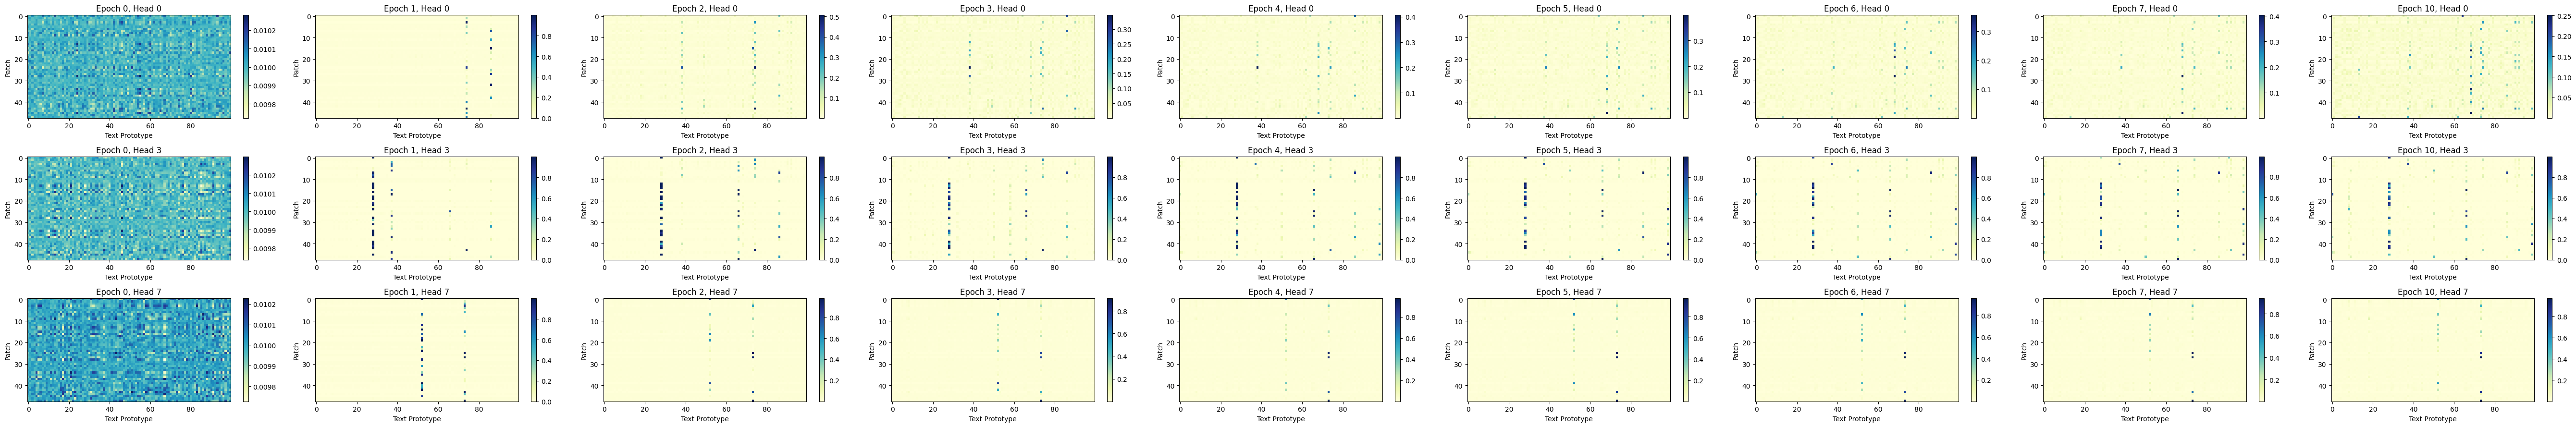

In [39]:
viz.plot(heads=[0, 3, 7], average_heads=False, save_path='attn_map_heads_diveristy.png')

Plot saved to: attn_map_avg_diversity.png


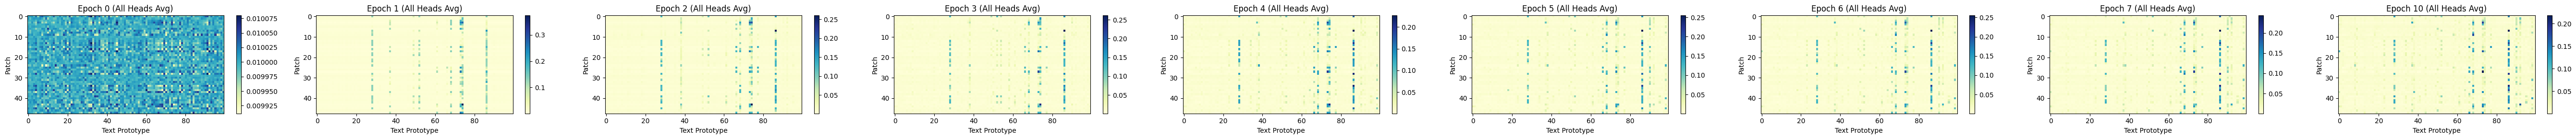

In [40]:
# Plot averaged attention maps
viz.plot(average_heads=True, save_path='attn_map_avg_diversity.png')

In [41]:
# Analyze token weights in top prototypes based on averaged attention map
analyze_top_prototypes(viz, epoch=3, average_heads=True, model=model, top_k_protos=5, top_k_tokens=30)

Top 5 prototypes at epoch 3 (All Heads Avg):

1. Prototype 86 (avg attention: 0.0727)
   (Using mapping weights from epoch 3)
   Top 30 tokens (by absolute weight):
     1. '355': +0.0358
     2. '[unused518]': +0.0346
     3. 'turnbull': +0.0337
     4. 'helmet': +0.0326
     5. 'roared': -0.0323
     6. 'hips': -0.0321
     7. 'oval': -0.0320
     8. 'toro': -0.0318
     9. 'justine': -0.0315
     10. 'washington': +0.0314
     11. 'george': -0.0313
     12. 'nebraska': +0.0308
     13. 'luxury': -0.0306
     14. 'hypothesis': -0.0304
     15. 'andrei': -0.0304
     16. 'ancestral': +0.0303
     17. '2021': +0.0301
     18. '##rain': +0.0298
     19. 'concealed': +0.0295
     20. '1958': -0.0294
     21. 'commitments': -0.0294
     22. 'assistance': -0.0294
     23. 'cade': +0.0293
     24. 'attackers': -0.0292
     25. 'valves': +0.0291
     26. '##aga': -0.0291
     27. 'dubois': -0.0289
     28. 'tattooed': +0.0289
     29. 'wanderers': +0.0288
     30. 'violet': -0.0287
   Protot

In [42]:
# Analyze token weights in top prototypes based on attention maps across heads
for i in range(8):
    print(f"Head {i}:")
    analyze_top_prototypes(viz, epoch=4, average_heads=False, head=i, model=model, top_k_protos=5, top_k_tokens=30)
    print()

Head 0:
Top 5 prototypes at epoch 4, head 0:

1. Prototype 68 (avg attention: 0.0392)
   (Using mapping weights from epoch 4)
   Top 30 tokens (by absolute weight):
     1. 'ذ': +0.0326
     2. 'remnant': +0.0294
     3. 'northwest': -0.0283
     4. 'cl': +0.0282
     5. 'impoverished': -0.0278
     6. 'richter': +0.0266
     7. 'cough': +0.0262
     8. '##liner': -0.0262
     9. '郡': -0.0262
     10. 'sketches': +0.0258
     11. 'dhabi': -0.0256
     12. '##sville': -0.0256
     13. '##ii': +0.0256
     14. 'cid': +0.0255
     15. '##ह': -0.0254
     16. 'invest': +0.0250
     17. 'townspeople': -0.0246
     18. 'oxfordshire': -0.0246
     19. 'listeners': -0.0244
     20. 'results': -0.0244
     21. 'europe': -0.0241
     22. '125': -0.0240
     23. 'guthrie': +0.0240
     24. '##pres': +0.0238
     25. 'groningen': +0.0238
     26. 'knows': -0.0237
     27. 'hampton': -0.0237
     28. '2010': +0.0237
     29. 'conjunction': -0.0237
     30. 'liked': +0.0233
   Prototype stats (absol

In [43]:
# Check the weights of time series related words in the top prototypes
check_timeseries_in_top_prototypes(viz, epoch=4, average_heads=True, model=model, timeseries_words=['seasonal', 'periodic'])

Time series words in top 5 prototypes (epoch 4, All Heads Avg):

1. Prototype 86 (avg attention: 0.0711)
--------------------------------------------------
  Time series word weights:
    'seasonal': 0.0209
    'periodic': 0.0034

  Top 5 words by absolute weight:
    1. '355': 0.034724
    2. '[unused518]': 0.034254
    3. 'helmet': 0.032668
    4. 'roared': -0.032577
    5. 'turnbull': 0.032532

2. Prototype 74 (avg attention: 0.0558)
--------------------------------------------------
  Time series word weights:
    'seasonal': -0.0099
    'periodic': -0.0003

  Top 5 words by absolute weight:
    1. 'ո': 0.033437
    2. 'dorothea': 0.032409
    3. 'haunted': 0.031837
    4. 'specialists': 0.031234
    5. 'seafood': -0.030611

3. Prototype 73 (avg attention: 0.0502)
--------------------------------------------------
  Time series word weights:
    'seasonal': 0.0032
    'periodic': 0.0115

  Top 5 words by absolute weight:
    1. '##dya': -0.030027
    2. 'reagan': 0.028287
    3. 'l

## 6. Save model checkpoint

In [35]:
import shutil
from google.colab import files

# Create a zip file of the entire checkpoint folder
shutil.make_archive('checkpoints', 'zip', './checkpoints')

# Download the zip file
files.download('checkpoints.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 7. Load saved model and make predictions on test set

In [44]:
# Load saved checkpoint
checkpoint = torch.load(f'checkpoints/{setting}-{args.model_comment}/checkpoint')
# checkpoint = torch.load(f'checkpoint')
model = Model(args).float().to(device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [46]:
# Make predictions on test set with saved model
test_data, test_loader = data_provider(args, 'test')
criterion, mae_metric = nn.MSELoss(), nn.L1Loss()
test_loss, test_mae_loss = vali(args, None, model, test_data, test_loader, criterion, mae_metric)

76it [01:32,  1.21s/it]


In [47]:
# Print test MSE loss and test MAE loss
print(f"Test Loss: {test_loss:.4f}, Test MAE Loss: {test_mae_loss:.4f}")

Test Loss: 0.3184, Test MAE Loss: 0.3795


## 8. Text prototype analysis

In [48]:
# Grab BERT's word embeddings
word_embed_tensor = model.llm_model.get_input_embeddings().weight.detach()

# Get text prototypes [V', d_llm]
# We permute the text prototypes, run through the Linear (V -> V'), then permute back
proto = model.mapping_layer(word_embed_tensor.permute(1, 0)).permute(1, 0)

# Convert both to NumPy
word_embed = word_embed_tensor.cpu().numpy()   # (V, d_llm)
proto = proto.detach().cpu().numpy()    # (V', d_llm)

# Stack and ready for UMAP
combine_embed = np.vstack([word_embed, proto])    # shape = (V + V', d_llm)

print(f"Shape of word embeddings: {word_embed.shape}")
print(f"Shape of prototypes: {proto.shape}")
print(f"Shape of combined embeddings: {combine_embed.shape}")

Shape of word embeddings: (30522, 768)
Shape of prototypes: (100, 768)
Shape of combined embeddings: (30622, 768)


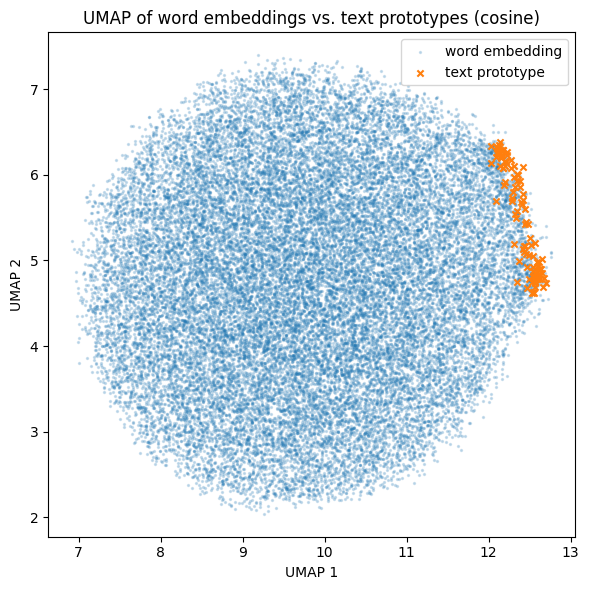

In [49]:
# Plot text prototypes and BERT's word embeddings on the same UMAP plot (cosine)
import umap.umap_ as umap

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Fit a UMAP reducer with cosine metric
reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42)
embed_2d = reducer.fit_transform(combine_embed)  # [V + V', 2]

# Split word embeddings vs. prototypes
xw, yw = embed_2d[: len(word_embed)].T
xp, yp = embed_2d[len(word_embed) :].T

# Scatter plot
ax.scatter(xw, yw, s=2, alpha=0.2, label='word embedding')
ax.scatter(xp, yp, s=20, c='C1', marker='x', label='text prototype')
ax.set_title("UMAP of word embeddings vs. text prototypes (cosine)")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.legend()
plt.tight_layout()
plt.show()

In [50]:
# Find which prototypes lie inside that cloud
x_min, x_max = xw.min(), xw.max()
y_min, y_max = yw.min(), yw.max()

inliers = np.where(
    (xp >= x_min) & (xp <= x_max) &
    (yp >= y_min) & (yp <= y_max)
)[0]

print("Prototypes inside the main word embeddings cloud:", inliers.tolist())

Prototypes inside the main word embeddings cloud: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


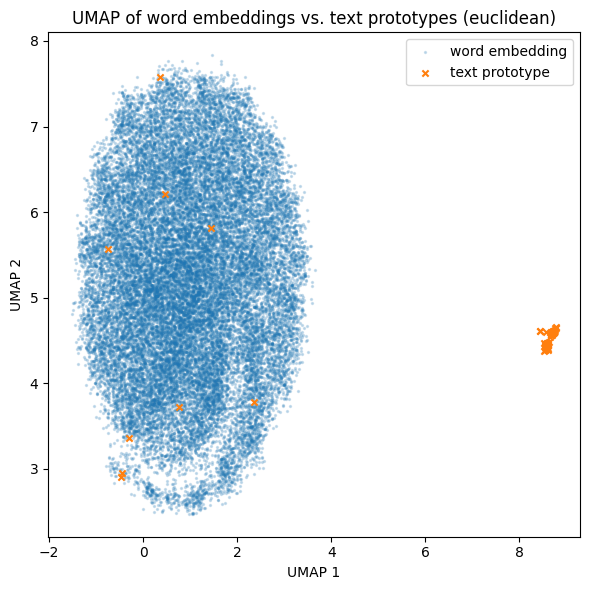

In [51]:
# Plot text prototypes and BERT's word embeddings on the same UMAP plot (euclidean)
import umap.umap_ as umap
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Fit a UMAP reducer with cosine metric
reducer = umap.UMAP(n_components=2, metric='euclidean', random_state=42)
embed_2d = reducer.fit_transform(combine_embed)  # [V + V', 2]

# Split word embeddings vs. prototypes
xw, yw = embed_2d[: len(word_embed)].T
xp, yp = embed_2d[len(word_embed) :].T

# Scatter plot
ax.scatter(xw, yw, s=2, alpha=0.2, label='word embedding')
ax.scatter(xp, yp, s=20, c='C1', marker='x', label='text prototype')
ax.set_title("UMAP of word embeddings vs. text prototypes (euclidean)")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.legend()
plt.tight_layout()
plt.show()

In [52]:
# Find which prototypes lie inside that cloud
x_min, x_max = xw.min(), xw.max()
y_min, y_max = yw.min(), yw.max()

inliers = np.where(
    (xp >= x_min) & (xp <= x_max) &
    (yp >= y_min) & (yp <= y_max)
)[0]

print("Prototypes inside the main word embeddings cloud:", inliers.tolist())

Prototypes inside the main word embeddings cloud: [10, 31, 37, 52, 55, 61, 68, 73, 95]


**Note:** In the UMAP plot, only 3 prototypes are inside the word embedding cloud, the majority of them are far away from it. The inliers all showed up in the top prototypes as we've seen before.

In [53]:
# Calculate cosine similarity matrix of the prototypes
import torch.nn.functional as F

norm_proto = F.normalize(torch.from_numpy(proto), p=2, dim=1)
proto_sim_mat = norm_proto @ norm_proto.T  # (V', V')
proto_sim_mat

tensor([[1.0000, 0.3395, 0.2131,  ..., 0.5021, 0.0992, 0.4589],
        [0.3395, 1.0000, 0.4989,  ..., 0.5038, 0.4607, 0.6139],
        [0.2131, 0.4989, 1.0000,  ..., 0.2475, 0.4651, 0.4327],
        ...,
        [0.5021, 0.5038, 0.2475,  ..., 1.0000, 0.3275, 0.5650],
        [0.0992, 0.4607, 0.4651,  ..., 0.3275, 1.0000, 0.3918],
        [0.4589, 0.6139, 0.4327,  ..., 0.5650, 0.3918, 1.0000]])

In [70]:
# Inspect the diversity of prototypes
iu = torch.triu_indices(100, 100, offset=1)   # upper triangle, no diagonal
sims = proto_sim_mat[iu[0], iu[1]]

# Calculate mean cosine similarity
mean_sim = sims.mean().item()

# Calculate the percentage of similarities above the threshold
threshold = 0.9
percent_high = ((sims >= threshold).sum() / len(sims)) * 100

# Get top 10 most dissimilar prototypes and their mean similarities
offdiag_mean_sims_per_proto = (proto_sim_mat.sum(dim=1) - 1.0) / (100 - 1)
top_10_proto_mean_sims, top_10_proto_idx = torch.topk(torch.abs(offdiag_mean_sims_per_proto), k=10, largest=False)

print(f"Mean cosine similarity: {mean_sim:.4f}")
print(f"Percentage of high similarities (above threshold = {threshold}): {percent_high:.4f}%")
print(f"Top 10 dissimilar prototypes: {top_10_proto_idx} and their similarities: {top_10_proto_mean_sims}")

Mean cosine similarity: 0.2693
Percentage of high similarities (above threshold = 0.9): 0.0000%
Top 10 dissimilar prototypes: tensor([73, 68, 52, 61, 37, 31, 86, 38, 10, 58]) and their similarities: tensor([0.0395, 0.0483, 0.0708, 0.1120, 0.1161, 0.1222, 0.1531, 0.1565, 0.1760,
        0.1826])


**Note:**
- The proximities in a 2D UMAP plot might not reflect the truth in 768D. But with cosine similarity, you can work with all of the prototypes' cooridinates directly.
- There are approx. 37% of prototype pairs of similarity >= 0.9, suggesting a prototpye collapse.
- Most of the top 10 dissimilar prototypes also appeared in the top prototypes before.

In [ ]:
# Create a new instance of the model
untrained_model = Model(args).float().to(device)

# Get text prototypes [V', d_llm]
untrained_proto = untrained_model.mapping_layer(word_embed_tensor.permute(1, 0)).permute(1, 0)

# Convert untrained prototypes to NumPy
untrained_proto = untrained_proto.detach().cpu().numpy()  # (V', d_llm)

# Stack and ready for UMAP
combine_embed = np.vstack([word_embed, untrained_proto])  # shape = (V + V', d_llm)

The prototype collapse is probably because the weights of the mapping layer (linear layer that maps LLM's vocabs to prototypes) have similar initialized values. So let's create a new (untrained) model and inspect its prototypes.

In [ ]:
# Plot untrained text prototypes and BERT's word embeddings on the same UMAP plot (cosine)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Fit a UMAP reducer with cosine metric
reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42)
embed_2d = reducer.fit_transform(combine_embed)   # [V + V', 2]

# Split word embeddings vs. prototypes
xw, yw = embed_2d[: len(word_embed)].T
xp, yp = embed_2d[len(word_embed) :].T

# Scatter plot
ax.scatter(xw, yw, s=2, alpha=0.2, label='word embedding')
ax.scatter(xp, yp, s=20, c='C1', marker='x', label='text prototype')
ax.set_title("UMAP of word embeddings vs. untrained text prototypes (cosine)")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Calculate cosine similarity matrix of the untrained prototypes
norm_untrained_proto = F.normalize(torch.from_numpy(untrained_proto), p=2, dim=1)
untrained_proto_sim_mat = norm_untrained_proto @ norm_untrained_proto.T  # (V', V')
untrained_proto_sim_mat

In [ ]:
# Inspect the diversity of prototypes
iu = torch.triu_indices(100, 100, offset=1)   # upper triangle, no diagonal
sims = untrained_proto_sim_mat[iu[0], iu[1]]

# Calculate mean cosine similarity
mean_sim = sims.mean().item()

# Calculate the percentage of similarities above the threshold
threshold = 0.9
percent_high = ((sims > threshold).sum() / len(sims)) * 100

print(f'Mean cosine similarity: {mean_sim:.4f}')
print(f'Percentage of high similarities (above threshold = {threshold}): {percent_high:.4f}%')

In [ ]:
# Plot untrained text prototypes and BERT's word embeddings on the same UMAP plot (euclidean)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Fit a UMAP reducer with cosine metric
reducer = umap.UMAP(n_components=2, metric='euclidean', random_state=42)
embed_2d = reducer.fit_transform(combine_embed)   # [V + V', 2]

# Split word embeddings vs. prototypes
xw, yw = embed_2d[: len(word_embed)].T
xp, yp = embed_2d[len(word_embed) :].T

# Scatter plot
ax.scatter(xw, yw, s=2, alpha=0.2, label='word embedding')
ax.scatter(xp, yp, s=20, c='C1', marker='x', label='text prototype')
ax.set_title("UMAP of word embeddings vs. untrained text prototypes (euclidean)")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.legend()
plt.tight_layout()
plt.show()

## 9. Tensorboard

In [ ]:
logdir = f'checkpoints/{setting}-{args.model_comment}/training_logs'

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {logdir}